# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

*Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?*

This problem is best suited for Classificaton. This is due to the nature of the output, where we require a determination of the student as "need early intervention", or not.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [393]:
# Import libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  


In [394]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns


Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [395]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students =student_data.shape[0]
n_features = student_data.shape[1]
n_passed = student_data[student_data['passed']=='yes'].shape[0]
n_failed = student_data[student_data['passed']=='no'].shape[0]
grad_rate = n_passed/float(n_students)
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 0.67%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [397]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [399]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
#y_all = y_all.replace(['yes', 'no'], [1, 0]) #swap yes/no to a numeric
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [400]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split( X_all, y_all, test_size=num_test, random_state=42)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [401]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit model to training data
print "Training {}...".format(clf.__class__.__name__)
timeDelta=train_classifier(clf, X_train, y_train)  # note: using entire training set here
print "Done!\nTraining time (secs): {:.3f}".format(timeDelta)
print clf  # you can inspect the learned model by printing it

Training GaussianNB...
Done!
Training time (secs): 0.001
GaussianNB()


In [402]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes'),end - start

print "Predicting labels using {}...".format(clf.__class__.__name__)
train_f1_score,timeDelta = predict_labels(clf, X_train, y_train)
print "Done!\nPrediction time (secs): {:.3f}".format(timeDelta)
print "F1 score for training set: {}".format(train_f1_score)


Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.80378250591


In [403]:
# Predict on test data

print "Predicting labels using {}...".format(clf.__class__.__name__)
test_f1_score,timeDelta = predict_labels(clf, X_train, y_train)
print "Done!\nPrediction time (secs): {:.3f}".format(timeDelta)
print "F1 score for test set: {}".format(test_f1_score)

Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.80378250591


In [404]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
print "------------------------------------------"
print "Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain)
print "F1 score for training set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta)
print "F1 score for test set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta)


------------------------------------------
Training set size: 300, Train time (secs): 0.001
F1 score for training set: 0.763358778626, Prediction time (secs): 0.001
F1 score for test set: 0.80378250591, Prediction time (secs): 0.001


In [405]:
# TODO: Train and predict using two other models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.naive_bayes import GaussianNB
#from sklearn.neural_network import MLPClassifier # not in vesion .17

def runCLF(X_train, y_train, X_test, y_test):
    scores={}

    clf = DecisionTreeClassifier(class_weight ="balanced")
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)
    
    clf = KNeighborsClassifier(n_jobs =-1)
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf=LinearSVC(class_weight="balanced")
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf=SVC(class_weight='balanced')
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf=linear_model.LogisticRegression(n_jobs =-1)
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf = ensemble.AdaBoostClassifier()
    scores[clf.__class__.__name__+"-plain"]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf = ensemble.AdaBoostClassifier(GaussianNB())
    scores[clf.__class__.__name__+"-GNB"]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,class_weight ="balanced"))
    scores[clf.__class__.__name__+"-DCT"]= train_predict(clf, X_train, y_train, X_test, y_test)
    
    clf = ensemble.RandomForestClassifier(n_jobs =-1,class_weight="balanced")
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    scoresDF= pd.DataFrame(scores,index=['testF1','testDelta','trainF1','trainDelta','timeTrain']).T
    return scoresDF.sort_values('testF1',ascending=False)

 
runs = 3
holdData=[]
for r in range(runs) :
    runNum=(r+1)*100
    print "calculating the" ,runNum,"set"
    holdData.append([runNum,runCLF(X_train[:runNum], y_train[:runNum], X_test, y_test)])
   


calculating the 100 set
calculating the 200 set
calculating the 300 set



training data size: 100
                            testF1  testDelta   trainF1  trainDelta  timeTrain
AdaBoostClassifier-plain  0.766917      0.006  0.948148       0.006      0.113
LogisticRegression        0.764706      0.000  0.859259       0.000      0.001
RandomForestClassifier    0.748092      0.120  0.992126       0.118      0.161

training data size: 200
                            testF1  testDelta   trainF1  trainDelta  timeTrain
AdaBoostClassifier-plain  0.828125      0.005  0.892734       0.006      0.103
LogisticRegression        0.791367      0.000  0.856187       0.000      0.002
KNeighborsClassifier      0.769231      0.118  0.880000       0.121      0.001

training data size: 300
                            testF1  testDelta   trainF1  trainDelta  timeTrain
LogisticRegression        0.805970      0.000  0.846847       0.000      0.003
AdaBoostClassifier-plain  0.781955      0.007  0.863741       0.006      0.125
KNeighborsClassifier      0.780142      0.117  0.880899 

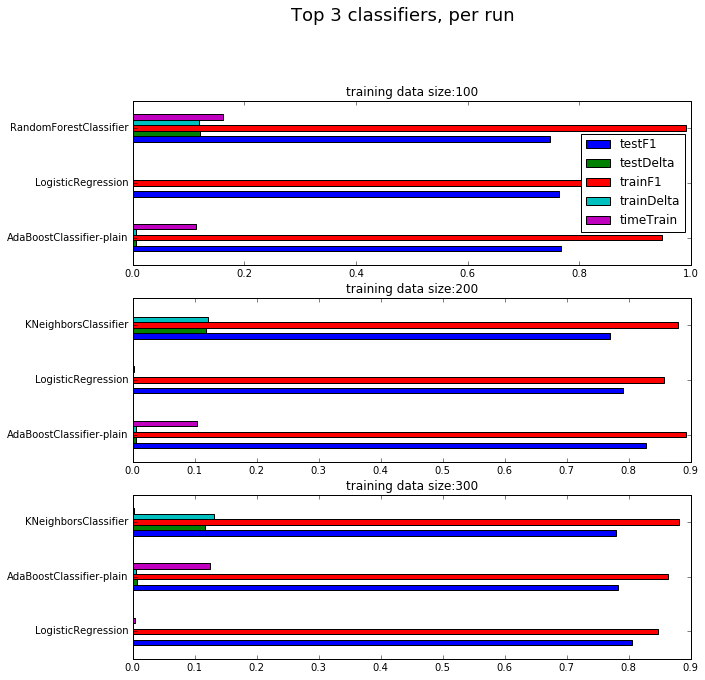

In [406]:
fig, axes = plt.subplots(nrows=3, ncols=1)
i=0
leg=True
for h in holdData:
    print "\ntraining data size:",h[0]
    print h[1][['testF1','testDelta','trainF1','trainDelta','timeTrain']][:3]
    h[1][['testF1','testDelta','trainF1','trainDelta','timeTrain']][:3].plot(
                                                                            kind='barh',
                                                                            ax=axes[i],
                                                                            legend=leg,
                                                                            figsize=(10,10),
                                                                            title="\ntraining data size:"+str(h[0]))
    leg=False
    i+=1
fig.suptitle('Top 3 classifiers, per run', fontsize=18, y=1.03)
#fig.figsize=(10,8)
fig.show()


* What is the theoretical O(n) time & space complexity in terms of input size?
* What are the general applications of this model? What are its strengths and weaknesses?
* Given what you know about the data so far, why did you choose this model to apply?

Experimentaion showed three different models that may best classify the data: LogisticRegression, AdaBoost, and KNeighbors.

LogisticRegression has an advantage over the others best methods, in that it is fast to query, and an eager learner, implying a lower resource usage and quicker prediction times. One disadvantage is that it must be retrained to use new data, but it's training time is also fairly quick.

AdaBoost is a boost algorithim, and we can see that it has the longest training time in any of the candidates, although prediction time is good.

KNeighbors is a lazy learner, and requires more memory resources, but timeTrain is very fast. Prediction time(testDelta&trainDelta) are highest of the candidates. This model uses the neighbors with similar features features to predict the label, and has an advantage in that data may be added to the model easily as it is aquired.

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [388]:
# TODO: Fine-tune your model and report the best F1 score

def modelTune(clf, params, X, y):
    #Fine tune model with grid search
    from sklearn.grid_search import GridSearchCV
    from sklearn.metrics import make_scorer, f1_score
    from sklearn.cross_validation import StratifiedShuffleSplit

    grid_search = GridSearchCV(clf, 
                               param_grid=params, 
                               cv=StratifiedShuffleSplit(y, random_state=42), 
                               n_jobs= -1,
                               scoring=make_scorer(f1_score, 
                                                   pos_label="yes",
                                                   greater_is_better=True)) 

    grid_search.fit(X, y)

    #reach into the grid search and pull out the best parameters, and set those on clf. probably not necesary, but easier to deal with
    bestGridParams={}
    for bp in grid_search.best_params_:
        bestGridParams[bp]=grid_search.best_params_[bp]

    clf.set_params(**bestGridParams)
    return clf

    # Check out each parameter combination and it's score:
    #for gs in grid_search.grid_scores_:
    #    print gs


In [389]:

print "best classifier was:"
clf=linear_model.LogisticRegression(n_jobs =-1)

params={'C' : [.005,.05,.5,1.,10.,100.,0.08],
        #'fit_intercept' : [True, False],
        #'class_weight': [ None,'balanced'],
        #'random_state' : [None,42],
        #'solver' : ['newton-cg', 'lbfgs', 'liblinear'],#, 'sag'],
        #'tol': [0.00001,0.0001,.001],
        #'penalty': ['l1', 'l2']
       }
print "\nOriginal clf:\n",clf #compare after gridsearch
test_def,testDelta_def,train_def,trainDelta_def,timeTrainf_def=train_predict(clf, X_train, y_train, X_test, y_test)

clf_tuned=modelTune(clf, params,X_train,y_train)
test_GS,testDelta_GS,train_GS,trainDelta_GS,timeTrainf_GS=train_predict(clf_tuned, X_train, y_train, X_test, y_test)

print "GridSearch best clf:\n",clf_tuned 

# the dataset is small gridsearch may not provide a better set of parameters than the default
# We'll check for that situation and return the best options F1 score for the full data set
print "------------------------------------------"
if test_GS >test_def: 
    print "\nFinal clf_GS, F1 score:",test_GS," def F1:",test_def,"\n" #after gridseach

else:
    print "\nFinal clf_def, F1 score:",test_def," GS F1:",test_GS,"\n" #after gridseach

best classifier was:

Original clf:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Anaconda2\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    157     pkg_name = mod_name.rpartition('.')[0]
    158     main_globals = sys.modules["__main__"].__dict__
    159     if alter_argv:
    160         sys.argv[0] = fname
    161     return _run_code(code, main_globals, None,
--> 162                      "__main__", fname, loader, pkg_name)
        fname = r'C:\Anaconda2\lib\site-packages\ipykernel\__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    163 
    164 def run_module(mod_name, init_globals=None,
    165                run_name=None, alter_sys=False):
    166     """Execute a module's code without importing it

...........................................................................
C:\Anaconda2\lib\runpy.py in _run_code(code=<code object <module> at 000000000226FBB0, file ...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': r'C:\Anaconda2\lib\site-packages\ipykernel\__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from 'C:\Anaconda2\lib\site-packages\ipykernel\kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname=r'C:\Anaconda2\lib\site-packages\ipykernel\__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 000000000226FBB0, file ...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': r'C:\Anaconda2\lib\site-packages\ipykernel\__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from 'C:\Anaconda2\lib\site-packages\ipykernel\kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
C:\Anaconda2\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    584         
    585         If a global instance already exists, this reinitializes and starts it
    586         """
    587         app = cls.instance(**kwargs)
    588         app.initialize(argv)
--> 589         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    590 
    591 #-----------------------------------------------------------------------------
    592 # utility functions, for convenience
    593 #-----------------------------------------------------------------------------

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    398         
    399         if self.poller is not None:
    400             self.poller.start()
    401         self.kernel.start()
    402         try:
--> 403             ioloop.IOLoop.instance().start()
    404         except KeyboardInterrupt:
    405             pass
    406 
    407 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
C:\Anaconda2\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
C:\Anaconda2\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Anaconda2\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'\nprint "best classifier was:"\nclf=linear_mod...est_def," GS F1:",test_GS,"\\n" #after gridseach', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-04-01T16:11:43.726000', u'msg_id': u'6B55CDE241B048508451C1991E72CA54', u'msg_type': u'execute_request', u'session': u'719FA251CC25477D9400B6D16AE9084D', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'6B55CDE241B048508451C1991E72CA54', 'msg_type': u'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['719FA251CC25477D9400B6D16AE9084D']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'\nprint "best classifier was:"\nclf=linear_mod...est_def," GS F1:",test_GS,"\\n" #after gridseach', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-04-01T16:11:43.726000', u'msg_id': u'6B55CDE241B048508451C1991E72CA54', u'msg_type': u'execute_request', u'session': u'719FA251CC25477D9400B6D16AE9084D', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'6B55CDE241B048508451C1991E72CA54', 'msg_type': u'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['719FA251CC25477D9400B6D16AE9084D'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'\nprint "best classifier was:"\nclf=linear_mod...est_def," GS F1:",test_GS,"\\n" #after gridseach', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-04-01T16:11:43.726000', u'msg_id': u'6B55CDE241B048508451C1991E72CA54', u'msg_type': u'execute_request', u'session': u'719FA251CC25477D9400B6D16AE9084D', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'6B55CDE241B048508451C1991E72CA54', 'msg_type': u'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'\nprint "best classifier was:"\nclf=linear_mod...est_def," GS F1:",test_GS,"\\n" #after gridseach', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'\nprint "best classifier was:"\nclf=linear_mod...est_def," GS F1:",test_GS,"\\n" #after gridseach'
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'\nprint "best classifier was:"\nclf=linear_mod...est_def," GS F1:",test_GS,"\\n" #after gridseach', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Print object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Print object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Print object>, <_ast.Print object>, <_ast.If object>], cell_name='<ipython-input-389-238ccd5d1420>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2820 
   2821         try:
   2822             for i, node in enumerate(to_run_exec):
   2823                 mod = ast.Module([node])
   2824                 code = compiler(mod, cell_name, "exec")
-> 2825                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 000000002113FAB0, file "<ipython-input-389-238ccd5d1420>", line 16>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 000000002113FAB0, file "<ipython-input-389-238ccd5d1420>", line 16>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 000000002113FAB0, file "<ipython-input-389-238ccd5d1420>", line 16>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
C:\cygwin\home\llathrop\projects\udacity-Projects\student_intervention\<ipython-input-389-238ccd5d1420> in <module>()
     11         #'penalty': ['l1', 'l2']
     12        }
     13 print "\nOriginal clf:\n",clf #compare after gridsearch
     14 test_def,testDelta_def,train_def,trainDelta_def,timeTrainf_def=train_predict(clf, X_train, y_train, X_test, y_test)
     15 
---> 16 clf_tuned=modelTune(clf, params,X_train,y_train)
     17 test_GS,testDelta_GS,train_GS,trainDelta_GS,timeTrainf_GS=train_predict(clf_tuned, X_train, y_train, X_test, y_test)
     18 
     19 print "GridSearch best clf:\n",clf_tuned 
     20 

...........................................................................
C:\cygwin\home\llathrop\projects\udacity-Projects\student_intervention\<ipython-input-388-205d55bcc19c> in modelTune(clf=LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False), params={'C': [0.005, 0.05, 0.5, 1.0, 10.0, 100.0, 0.08]}, X=     school_GP  school_MS  sex_F  sex_M  age  ad...   1       5         4  

[300 rows x 48 columns], y=210    0
75     1
104    1
374    1
16     1
66 ...   0
348    1
102    1
Name: passed, dtype: int64)
     12                                n_jobs= -1,
     13                                scoring=make_scorer(f1_score, 
     14                                                    pos_label="yes",
     15                                                    greater_is_better=True)) 
     16 
---> 17     grid_search.fit(X, y)
     18 
     19     #reach into the grid search and pull out the best parameters, and set those on clf. probably not necesary, but easier to deal with
     20     bestGridParams={}
     21     for bp in grid_search.best_params_:

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\grid_search.py in fit(self=GridSearchCV(cv=StratifiedShuffleSplit(labels=[0...=make_scorer(f1_score, pos_label=yes), verbose=0), X=     school_GP  school_MS  sex_F  sex_M  age  ad...   1       5         4  

[300 rows x 48 columns], y=210    0
75     1
104    1
374    1
16     1
66 ...   0
348    1
102    1
Name: passed, dtype: int64)
    799         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    800             Target relative to X for classification or regression;
    801             None for unsupervised learning.
    802 
    803         """
--> 804         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(...make_scorer(f1_score, pos_label=yes), verbose=0)>
        X =      school_GP  school_MS  sex_F  sex_M  age  ad...   1       5         4  

[300 rows x 48 columns]
        y = 210    0
75     1
104    1
374    1
16     1
66 ...   0
348    1
102    1
Name: passed, dtype: int64
        self.param_grid = {'C': [0.005, 0.05, 0.5, 1.0, 10.0, 100.0, 0.08]}
    805 
    806 
    807 class RandomizedSearchCV(BaseSearchCV):
    808     """Randomized search on hyper parameters.

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\grid_search.py in _fit(self=GridSearchCV(cv=StratifiedShuffleSplit(labels=[0...=make_scorer(f1_score, pos_label=yes), verbose=0), X=     school_GP  school_MS  sex_F  sex_M  age  ad...   1       5         4  

[300 rows x 48 columns], y=210    0
75     1
104    1
374    1
16     1
66 ...   0
348    1
102    1
Name: passed, dtype: int64, parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    548         )(
    549             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    550                                     train, test, self.verbose, parameters,
    551                                     self.fit_params, return_parameters=True,
    552                                     error_score=self.error_score)
--> 553                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    554                 for train, test in cv)
    555 
    556         # Out is a list of triplet: score, estimator, n_test_samples
    557         n_fits = len(out)

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    807             if pre_dispatch == "all" or n_jobs == 1:
    808                 # The iterable was consumed all at once by the above for loop.
    809                 # No need to wait for async callbacks to trigger to
    810                 # consumption.
    811                 self._iterating = False
--> 812             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    813             # Make sure that we get a last message telling us we are done
    814             elapsed_time = time.time() - self._start_time
    815             self._print('Done %3i out of %3i | elapsed: %s finished',
    816                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Apr 01 16:11:45 2016
PID: 15024                           Python 2.7.11: C:\Anaconda2\python.exe
...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\externals\joblib\parallel.pyc in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\cross_validation.pyc in _fit_and_score(estimator=LogisticRegression(C=0.005, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False), X=     school_GP  school_MS  sex_F  sex_M  age  ad...   1       5         4  

[300 rows x 48 columns], y=210    0
75     1
104    1
374    1
16     1
66 ...   0
348    1
102    1
Name: passed, dtype: int64, scorer=make_scorer(f1_score, pos_label=yes), train=array([119, 150, 250,  77, 297,  40, 188, 218, 1... 146, 113, 127, 247, 111, 102, 255], dtype=int64), test=array([ 61, 241, 277, 235, 294,  44,  72, 200,  ... 5, 180,
        20, 197,  34, 158], dtype=int64), verbose=0, parameters={'C': 0.005}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1545                              " numeric value. (Hint: if using 'raise', please"
   1546                              " make sure that it has been spelled correctly.)"
   1547                              )
   1548 
   1549     else:
-> 1550         test_score = _score(estimator, X_test, y_test, scorer)
   1551         if return_train_score:
   1552             train_score = _score(estimator, X_train, y_train, scorer)
   1553 
   1554     scoring_time = time.time() - start_time

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\cross_validation.pyc in _score(estimator=LogisticRegression(C=0.005, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False), X_test=     school_GP  school_MS  sex_F  sex_M  age  ad...    1       3         0  

[30 rows x 48 columns], y_test=366    1
205    0
191    0
259    0
188    0
287...   1
261    0
242    0
Name: passed, dtype: int64, scorer=make_scorer(f1_score, pos_label=yes))
   1601 def _score(estimator, X_test, y_test, scorer):
   1602     """Compute the score of an estimator on a given test set."""
   1603     if y_test is None:
   1604         score = scorer(estimator, X_test)
   1605     else:
-> 1606         score = scorer(estimator, X_test, y_test)
   1607     if not isinstance(score, numbers.Number):
   1608         raise ValueError("scoring must return a number, got %s (%s) instead."
   1609                          % (str(score), type(score)))
   1610     return score

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\metrics\scorer.pyc in __call__(self=make_scorer(f1_score, pos_label=yes), estimator=LogisticRegression(C=0.005, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False), X=     school_GP  school_MS  sex_F  sex_M  age  ad...    1       3         0  

[30 rows x 48 columns], y_true=366    1
205    0
191    0
259    0
188    0
287...   1
261    0
242    0
Name: passed, dtype: int64, sample_weight=None)
     85             return self._sign * self._score_func(y_true, y_pred,
     86                                                  sample_weight=sample_weight,
     87                                                  **self._kwargs)
     88         else:
     89             return self._sign * self._score_func(y_true, y_pred,
---> 90                                                  **self._kwargs)
     91 
     92 
     93 class _ProbaScorer(_BaseScorer):
     94     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.pyc in f1_score(y_true=366    1
205    0
191    0
259    0
188    0
287...   1
261    0
242    0
Name: passed, dtype: int64, y_pred=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..., 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64), labels=None, pos_label='yes', average='binary', sample_weight=None)
    634 
    635 
    636     """
    637     return fbeta_score(y_true, y_pred, 1, labels=labels,
    638                        pos_label=pos_label, average=average,
--> 639                        sample_weight=sample_weight)
        average = 'binary'
    640 
    641 
    642 def fbeta_score(y_true, y_pred, beta, labels=None, pos_label=1,
    643                 average='binary', sample_weight=None):

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.pyc in fbeta_score(y_true=366    1
205    0
191    0
259    0
188    0
287...   1
261    0
242    0
Name: passed, dtype: int64, y_pred=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..., 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64), beta=1, labels=None, pos_label='yes', average='binary', sample_weight=None)
    751                                                  beta=beta,
    752                                                  labels=labels,
    753                                                  pos_label=pos_label,
    754                                                  average=average,
    755                                                  warn_for=('f-score',),
--> 756                                                  sample_weight=sample_weight)
    757     return f
    758 
    759 
    760 def _prf_divide(numerator, denominator, metric, modifier, average, warn_for):

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.pyc in precision_recall_fscore_support(y_true=array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,..., 1, 1,
       1, 1, 1, 1, 1, 0, 0], dtype=int64), y_pred=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..., 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int64), beta=1, labels=None, pos_label='yes', average='binary', warn_for=('f-score',), sample_weight=None)
    979                 if len(present_labels) < 2:
    980                     # Only negative labels
    981                     return (0., 0., 0., 0)
    982                 else:
    983                     raise ValueError("pos_label=%r is not a valid label: %r" %
--> 984                                      (pos_label, present_labels))
    985             labels = [pos_label]
    986     if labels is None:
    987         labels = present_labels
    988         n_labels = None

ValueError: pos_label='yes' is not a valid label: array([0, 1], dtype=int64)
___________________________________________________________________________

In [378]:
clf=ensemble.AdaBoostClassifier()
params={'n_estimators' : [25,50,75], 
        'learning_rate' :[.96,1,1.4]
       }
print "next best: AdaBoostClassifier\n",clf
test_def,testDelta_def,train_def,trainDelta_def,timeTrainf_def=train_predict(clf, X_train, y_train, X_test, y_test)

clf_tuned=modelTune(clf, params,X_train,y_train)
test_GS,testDelta_GS,train_GS,trainDelta_GS,timeTrainf_GS=train_predict(clf_tuned, X_train, y_train, X_test, y_test)

print "GridSearch best clf:\n",clf_tuned 

# the dataset is small gridsearch may not provide a better set of parameters than the default
# We'll check for that situation and return the best options F1 score for the full data set
print "------------------------------------------"
if test_GS >test_def: 
    print "\nFinal clf_GS, F1 score:",test_GS," def F1:",test_def,"\n" #after gridseach

else:
    print "\nFinal clf_def, F1 score:",test_def," GS F1:",test_GS,"\n" #after gridseach

next best: AdaBoostClassifier
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
GridSearch best clf:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.96, n_estimators=25, random_state=None)
------------------------------------------

Final clf_def, F1 score: 0.781954887218  GS F1: 0.766917293233 



In [377]:
clf=KNeighborsClassifier(n_jobs =-1)
params={'leaf_size' : [7,15,22,30,37,45,60], 
        'n_neighbors' : [7,15,22,30,37,45,60], 
        'weights':['uniform','distance'], 'p':[1,2]
       }
print "next best: KNeighborsClassifier\n",clf
test_def,testDelta_def,train_def,trainDelta_def,timeTrainf_def=train_predict(clf, X_train, y_train, X_test, y_test)

clf_tuned=modelTune(clf, params,X_train,y_train)
test_GS,testDelta_GS,train_GS,trainDelta_GS,timeTrainf_GS=train_predict(clf_tuned, X_train, y_train, X_test, y_test)

print "GridSearch best clf:\n",clf_tuned 

# the dataset is small gridsearch may not provide a better set of parameters than the default
# We'll check for that situation and return the best options F1 score for the full data set
print "------------------------------------------"
if test_GS >test_def: 
    print "\nFinal clf_GS, F1 score:",test_GS," def F1:",test_def,"\n" #after gridseach

else:
    print "\nFinal clf_def, F1 score:",test_def," GS F1:",test_GS,"\n" #after gridseach

next best: KNeighborsClassifier
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
GridSearch best clf:
KNeighborsClassifier(algorithm='auto', leaf_size=22, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=45, p=2,
           weights='uniform')
------------------------------------------

Final clf_def, F1 score: 0.780141843972  GS F1: 0.779220779221 



#EOF